# Experiment to compaire model anf forecast uncertainty of simple and complex models

In [2]:
import numpy as np
import pandas as pd

import prosper_nn as pnn
from prosper_nn.models.hcnn import HCNN
from prosper_nn.models.ensemble import Ensemble
import prosper_nn.utils.generate_time_series_data as gtsd
import prosper_nn.utils.neuron_correlation_hidden_layers as nchl
import prosper_nn.utils.create_input_ecnn_hcnn as ci
import prosper_nn.utils.visualization as visualization
from prosper_nn.utils import visualize_forecasts
from prosper_nn.utils import sensitivity_analysis
import torch
from tqdm import trange
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams["figure.figsize"] = (10, 14)
torch.set_default_dtype(torch.float32)
torch.set_default_device("cuda")

### Basic settings

In [3]:
past_horizon = 40
forecast_horizon = 40
batchsize = 8
n_data = 200

In [25]:
def lorenz(xyz, s=10, r=28, b=2.6667):
    x, y, z = xyz
    x_dot = s * (y - x)
    y_dot = r * x - y - x * z
    z_dot = x * y - b * z
    return np.array([x_dot, y_dot, z_dot])


# initial_state = torch.tensor([0., 1., 1.05])
n_data = 20
len_rec = 5000

data = []
initial_state = torch.randn(3)
while len(data) < n_data:
    x = torch.randn(3) * np.array([10, 10, 10]) + np.array([0, 0, 25])
    x_traj = []
    for j in range(len_rec):
        x = x + lorenz(x) * 0.01
        x_traj.append(x)
    x_traj = torch.stack(x_traj)
    if np.linalg.norm(x_traj[-1]) > 100:
        print("blow up")
        continue  # skip this trajectory if it blows up
    data.append(x_traj)
data = torch.stack(data)
print(data.shape)

torch.Size([20, 5000, 3])


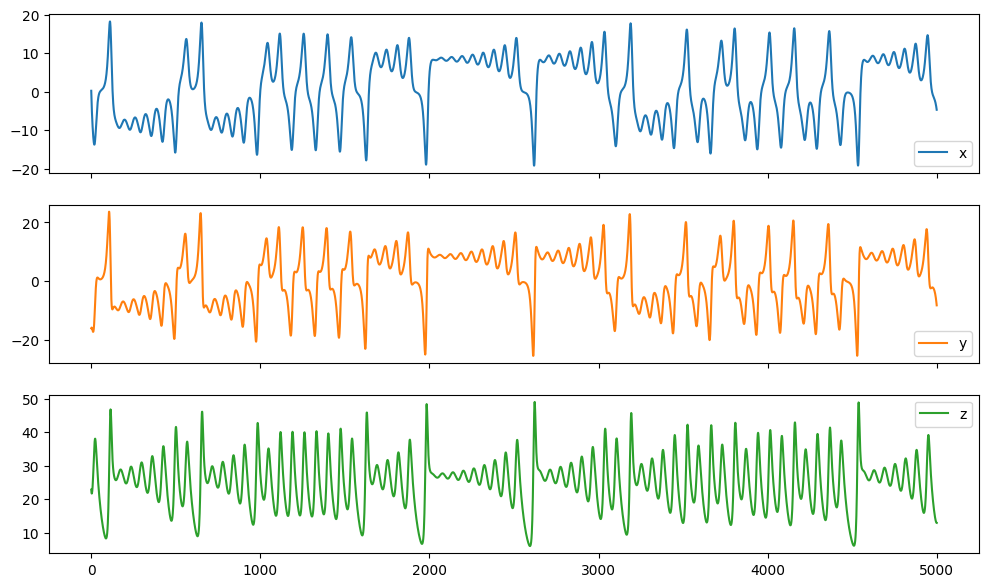

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

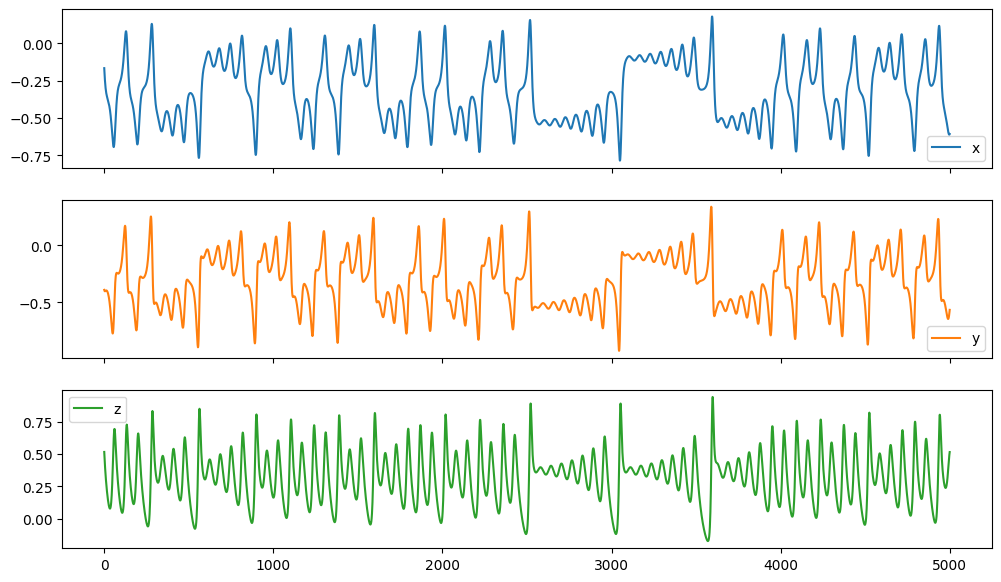

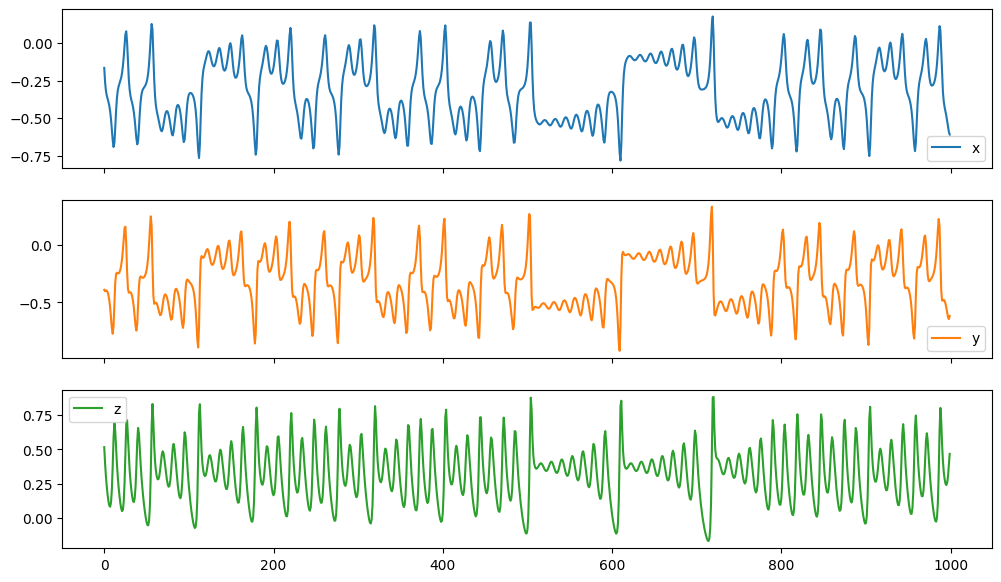

In [30]:
pd.DataFrame(data[2].numpy(), columns=["x", "y", "z"]).plot(
    subplots=True, figsize=(12, 7)
)
plt.show()
# normalized data [-1, 1]
data = (data - data.min()) / (data.max() - data.min()) * 2 - 1
pd.DataFrame(data[2].numpy(), columns=["x", "y", "z"]).plot(
    subplots=True, figsize=(12, 7)
)
plt.show()
# resample data to 1000
data = data[:, ::5]
pd.DataFrame(data[2].numpy(), columns=["x", "y", "z"]).plot(
    subplots=True, figsize=(12, 7)
)
plt.show()

In [31]:
past_horizon = 100
forecast_horizon = 50
batchsize = 32

In [37]:
batched_data = []
for i in range(n_data):
    batched_data.append(
        ci.create_input(
            Y=data[i],
            past_horizon=past_horizon,
            forecast_horizon=forecast_horizon,
            batchsize=batchsize,
        )
    )
batched_data = torch.concatenate(batched_data)
print(batched_data.shape)

torch.Size([560, 100, 32, 3])


C:\Users\Max\AppData\Local\Temp\ipykernel_18760\881908831.py:3: UserWarning: The number of sequences generated from the data are not a multiple of batchsize. The first 5 sequences will be discarded.
  batched_data.append(ci.create_input(Y=data[i], past_horizon=past_horizon, forecast_horizon=forecast_horizon, batchsize=batchsize))


### First Experiment (Sinwave as a simple and fully deterministic data generating process)

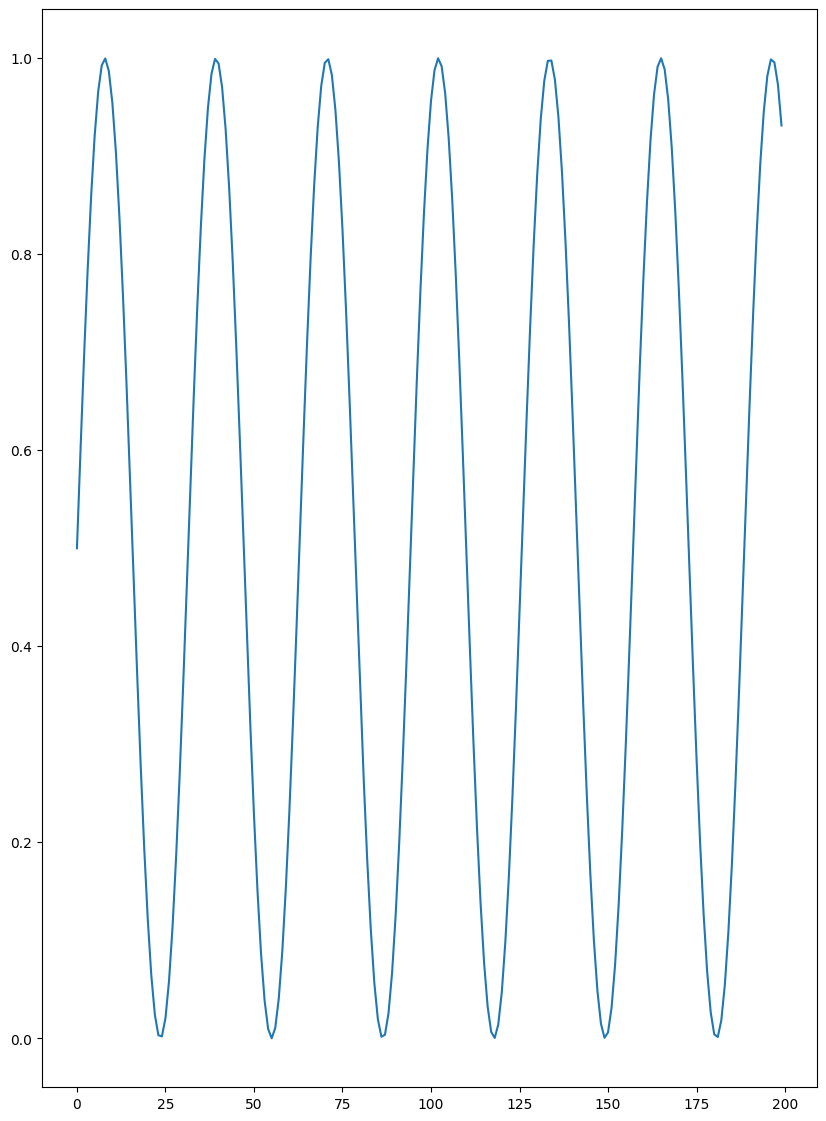

torch.Size([200])
torch.Size([200, 1])


C:\Users\Max\AppData\Local\Temp\ipykernel_20252\472164575.py:9: UserWarning: The number of sequences generated from the data are not a multiple of batchsize. The first 1 sequences will be discarded.
  Y_batches = ci.create_input(


torch.Size([20, 40, 8, 1])

In [14]:
omega = 0.2
data = (
    torch.sin(torch.arange(0, n_data * omega, omega)) + 1
) / 2  # sin(omega * x) and normalize to [0,1]
plt.plot(data.cpu().numpy())
plt.show()
print(data.shape)

Y = data.unsqueeze(1)
print(Y.shape)
Y_batches = ci.create_input(
    Y=Y,
    past_horizon=past_horizon,
    batchsize=batchsize,
    forecast_horizon=forecast_horizon,
)
Y_batches.shape

In [65]:
n_features_Y = 3
n_state_neurons = 50
sparsity = 0.1
n_models = 20
lstm = False

small_hcnn_model = HCNN(
    n_state_neurons=n_state_neurons,
    n_features_Y=n_features_Y,
    past_horizon=past_horizon,
    forecast_horizon=forecast_horizon,
    sparsity=sparsity,
    lstm=lstm,
)
small_hcnn_ensemble = Ensemble(
    model=small_hcnn_model,
    n_models=n_models,
    sparsity=sparsity,
    combination_type="mean",
)

targets = torch.zeros((past_horizon, batchsize, n_features_Y))
optimizer = torch.optim.Adam(small_hcnn_ensemble.parameters(), lr=0.001)
loss_function = torch.nn.MSELoss()

In [66]:
epochs = 50
small_hcnn_ensemble.train()
total_loss = epochs * [0]
with trange(epochs, desc="Model Training", unit="epoch") as tepoch:
    for epoch in tepoch:
        for batch_index in range(0, Y_batches.shape[0]):
            small_hcnn_ensemble.zero_grad()

            Y_batch = Y_batches[batch_index]
            ensemble_output = small_hcnn_ensemble(Y_batch)
            outputs, mean = torch.split(ensemble_output, n_models)
            mean = torch.squeeze(mean, 0)
            past_errors, forecasts = torch.split(outputs, past_horizon, dim=1)

            losses = [
                loss_function(past_errors[j][i], targets[i])
                for j in range(n_models)
                for i in range(past_horizon)
            ]
            loss = sum(losses) / (n_models * past_horizon)
            loss.backward()

            optimizer.step()

            mean_loss = (
                sum([loss_function(mean[i], targets[i]) for i in range(past_horizon)])
                / past_horizon
            )
            total_loss[epoch] += mean_loss.detach()
        tepoch.set_postfix(loss=loss.item())

Model Training: 100%|██████████| 50/50 [28:10<00:00, 33.82s/epoch, loss=0.00515]


In [67]:
torch.save(small_hcnn_ensemble, f"small_hcnn_ensemble_{n_models}.pt")

In [20]:
Y[: past_horizon + forecast_horizon].shape

torch.Size([80, 1])

In [35]:
n_models = 100
small_hcnn_ensemble = torch.load(f"small_hcnn_ensemble_{n_models}.pt")

In [36]:
test_batch = Y[: past_horizon + forecast_horizon].unsqueeze(1)
print(test_batch.shape)
with torch.no_grad():
    small_hcnn_ensemble.eval()

    output_forecast = small_hcnn_ensemble(test_batch[:past_horizon])
    forecasts = output_forecast[0, past_horizon:]

torch.Size([80, 1, 1])


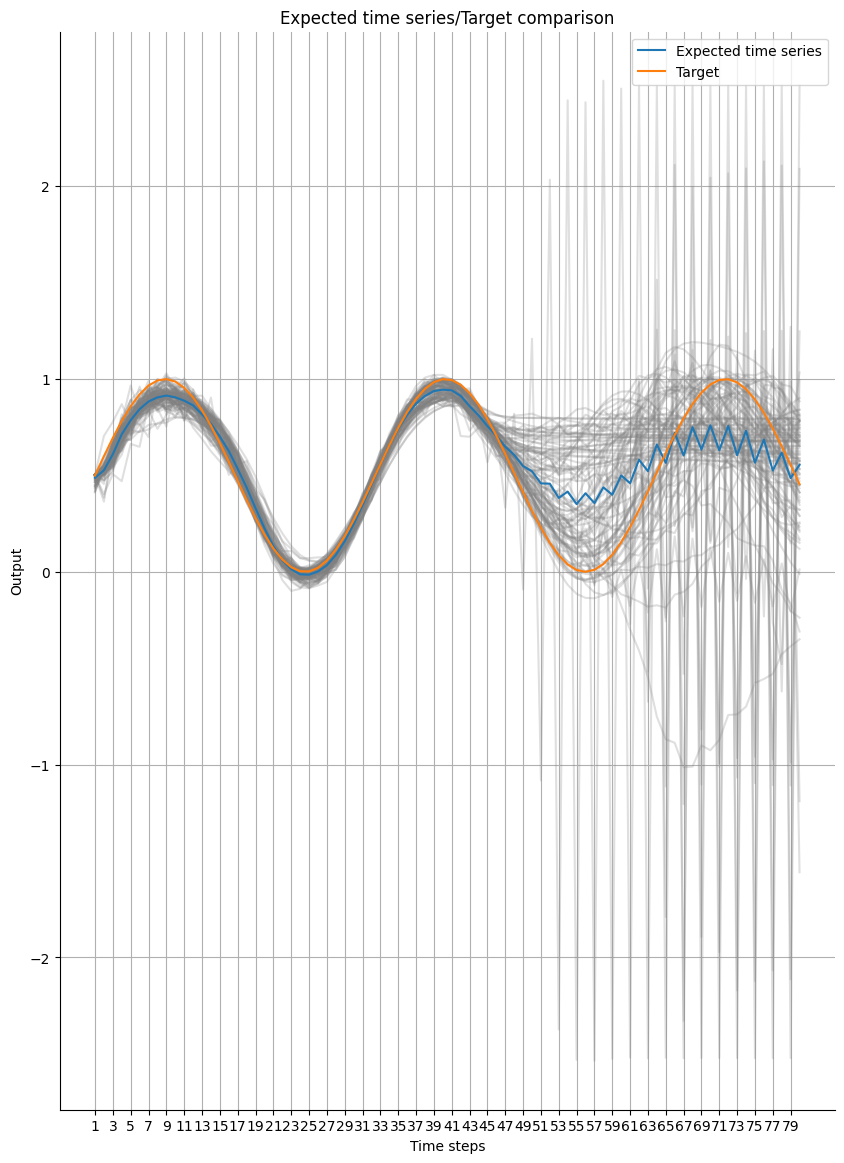

In [37]:
expected_timeseries = torch.cat(
    (
        torch.add(output_forecast[-1, :past_horizon], test_batch[:past_horizon]),
        output_forecast[-1, past_horizon:],
    ),
    dim=0,
).detach()
expected_timeseries_outputs = torch.cat(
    (
        torch.add(output_forecast[:-1, :past_horizon], test_batch[:past_horizon]),
        output_forecast[:-1, past_horizon:],
    ),
    dim=1,
).detach()

visualize_forecasts.plot_time_series(
    expected_time_series=expected_timeseries[:, 0, 0],
    target=test_batch[:, 0, 0],
    uncertainty=expected_timeseries_outputs[:, :, 0, 0].T,
)

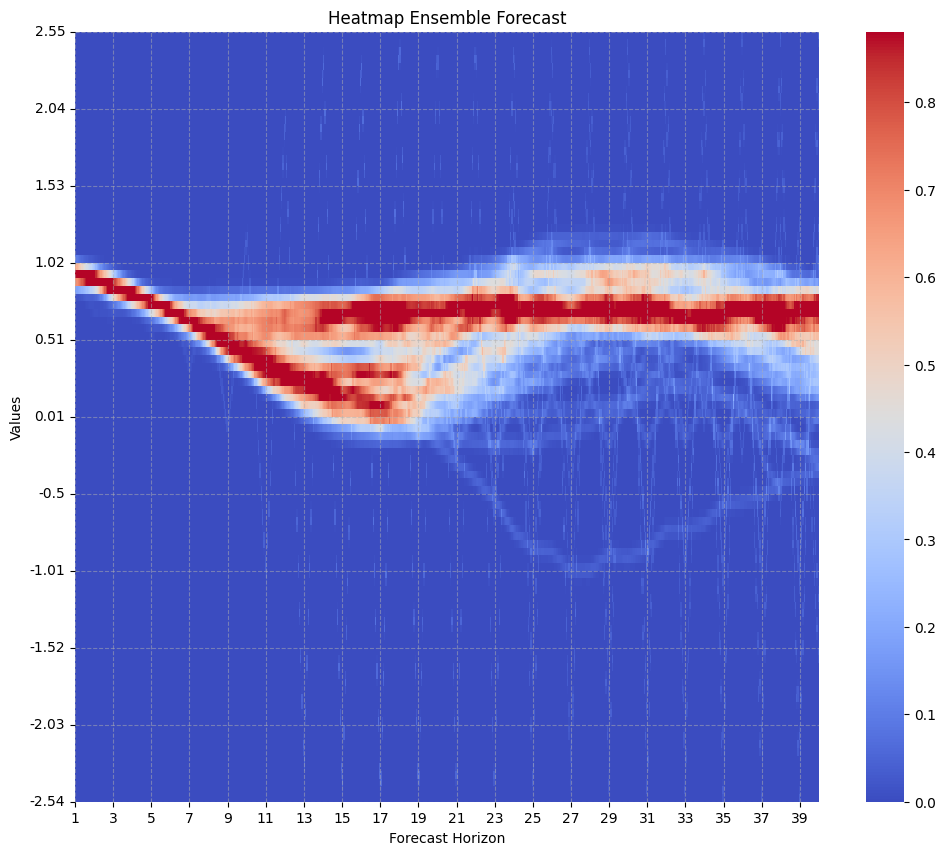

In [38]:
# mpl.rcParams['figure.figsize'] = (16,7)
# from torch.nn.functional import interpolate
fig = visualize_forecasts.heatmap_forecasts(
    expected_timeseries_outputs[:, past_horizon:, 0, 0].T, figsize=(12, 10)
)
# plt.plot(interpolate(expected_timeseries.transpose(0,2), 15*(forecast_horizon-1), mode="linear")[0, 0, :], color="red", label="Expected")
# plt.plot(interpolate(test_batch.transpose(0,2), 15*(forecast_horizon-1), mode="linear")[0, 0, :], color="black", linestyle="--", label="Target")
# plt.legend()
plt.show()

In [41]:
expected_timeseries_outputs[:-1, :, 0, 0].shape

torch.Size([99, 80])

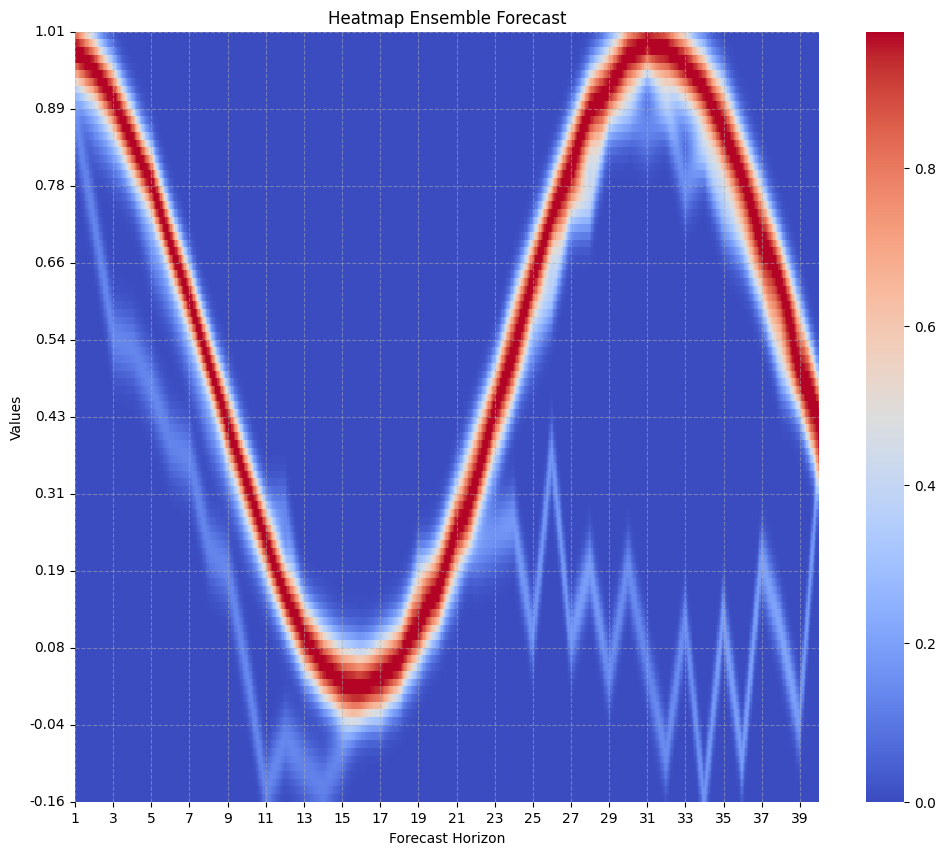

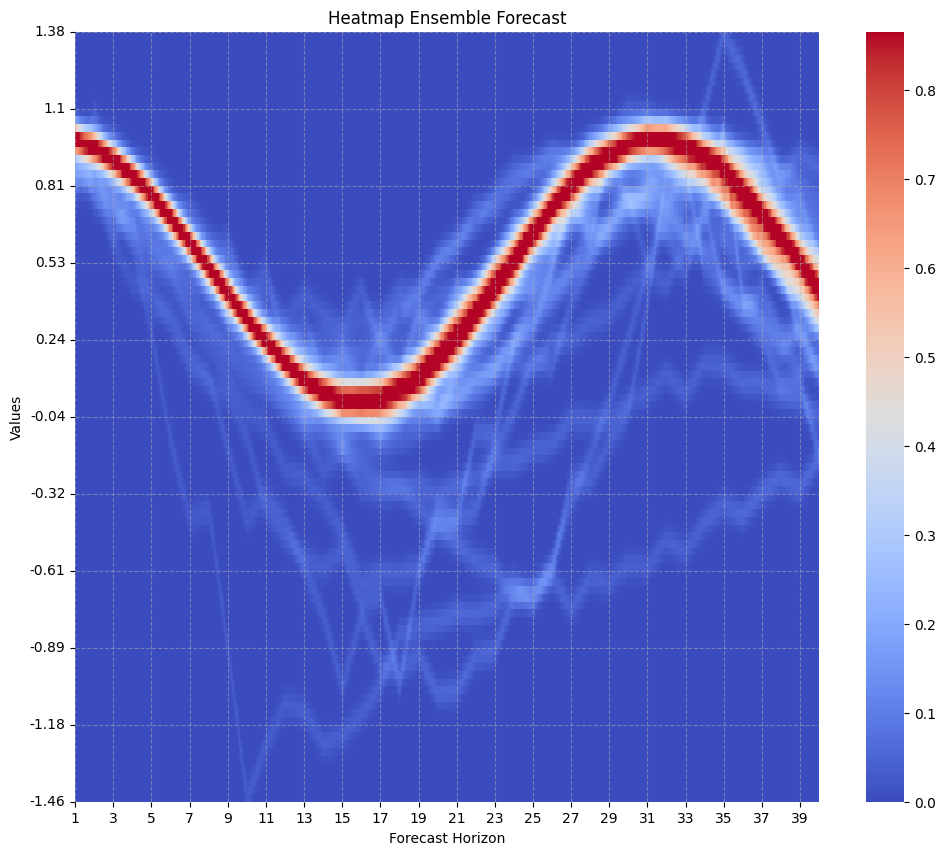

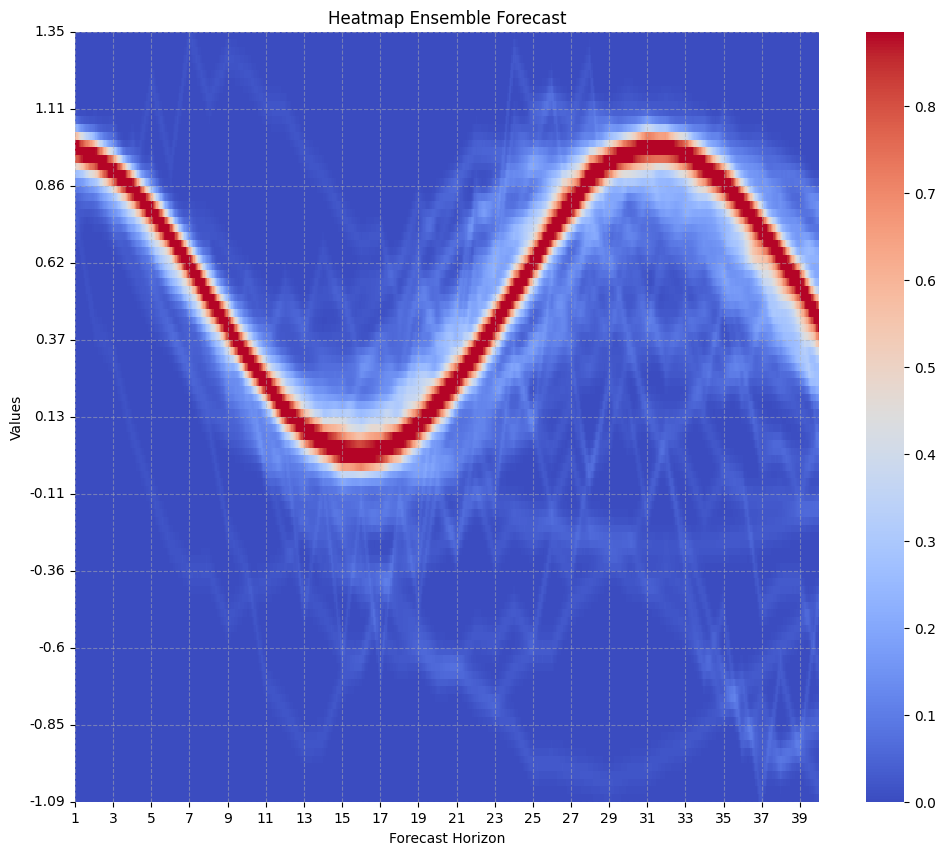

In [68]:
test_batch = Y[: past_horizon + forecast_horizon].unsqueeze(1)
vars = []
for n_model in [10, 50, 100]:
    model = torch.load(f"small_hcnn_ensemble_{n_model}.pt")
    with torch.no_grad():
        model.eval()

        output_forecast = model(test_batch[:past_horizon])
        forecasts = output_forecast[0, past_horizon:]

    expected_timeseries = torch.cat(
        (
            torch.add(output_forecast[-1, :past_horizon], test_batch[:past_horizon]),
            output_forecast[-1, past_horizon:],
        ),
        dim=0,
    ).detach()
    expected_timeseries_outputs = torch.cat(
        (
            torch.add(output_forecast[:-1, :past_horizon], test_batch[:past_horizon]),
            output_forecast[:-1, past_horizon:],
        ),
        dim=1,
    ).detach()
    fig = visualize_forecasts.heatmap_forecasts(
        expected_timeseries_outputs[:, past_horizon:, 0, 0].T, figsize=(12, 10)
    )
    plt.show()

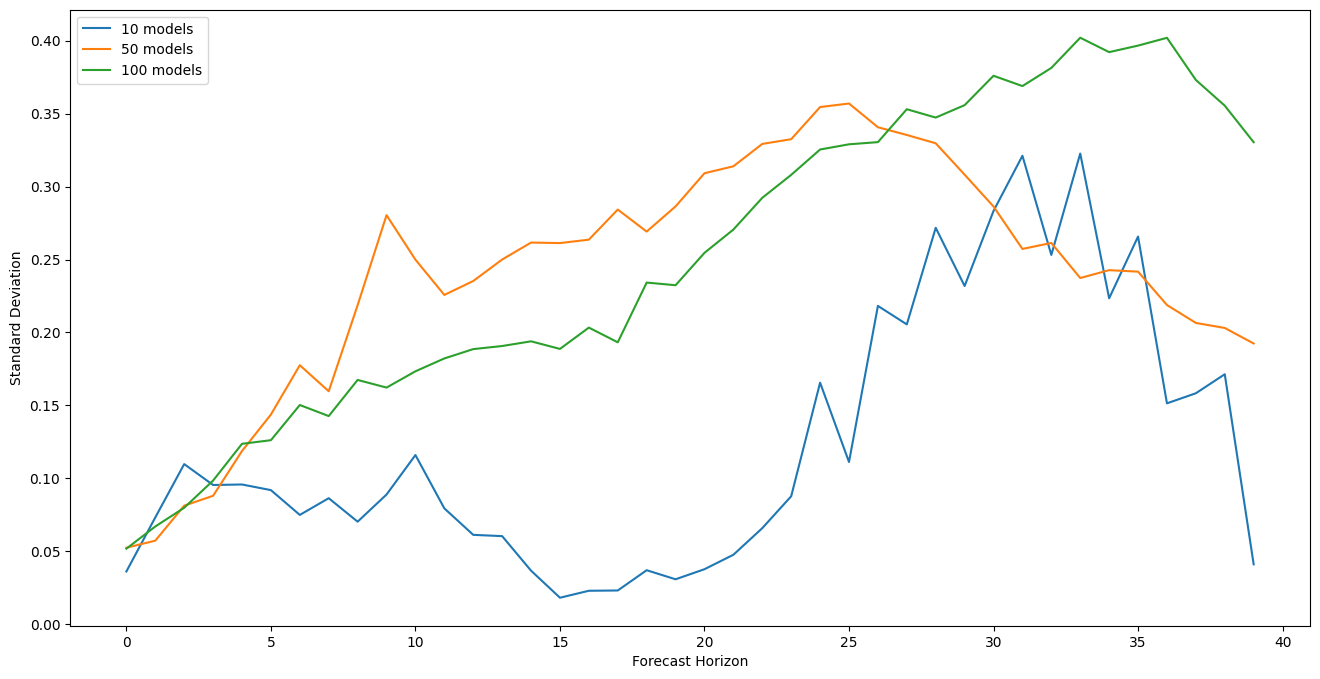

In [75]:
test_batch = Y[: past_horizon + forecast_horizon].unsqueeze(1)
vars = []
fig = plt.figure(figsize=(16, 8))
for n_model in [10, 50, 100]:
    model = torch.load(f"small_hcnn_ensemble_{n_model}.pt")
    with torch.no_grad():
        model.eval()

        output_forecast = model(test_batch[:past_horizon])
        forecasts = output_forecast[0, past_horizon:]

    expected_timeseries = torch.cat(
        (
            torch.add(output_forecast[-1, :past_horizon], test_batch[:past_horizon]),
            output_forecast[-1, past_horizon:],
        ),
        dim=0,
    ).detach()
    expected_timeseries_outputs = torch.cat(
        (
            torch.add(output_forecast[:-1, :past_horizon], test_batch[:past_horizon]),
            output_forecast[:-1, past_horizon:],
        ),
        dim=1,
    ).detach()
    var = np.sqrt(np.var(expected_timeseries_outputs[:, :, 0, 0].numpy(), axis=0))
    vars.append(var)
    plt.plot(var[past_horizon:], label=f"{n_model} models")
plt.xlabel("Forecast Horizon")
plt.ylabel("Standard Deviation")
plt.legend()
plt.show()

In [ ]:
import pandas as pd

var_Df = pd.DataFrame(
    vars,
    columns=[f"t+{i}" for i in range(1, forecast_horizon + 1)],
    index=[f"{n_model} models" for n_model in [10, 50, 100]],
)

In [3]:
from scipy.io.arff import loadarff

train_arff = loadarff("ECG5000_TRAIN.arff")
test_arff = loadarff("ECG5000_TEST.arff")

In [21]:
train_data = []
for i in range(len(train_arff[0])):
    signal = np.array([x for x in train_arff[0][i].tolist() if type(x) == float])
    train_data.append(signal)
train_data = np.concatenate(train_data)
test_data = []
for i in range(len(test_arff[0])):
    signal = np.array([x for x in test_arff[0][i].tolist() if type(x) == float])
    test_data.append(signal)
test_data = np.concatenate(test_data)

In [40]:
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import decimate

scaler = MinMaxScaler()
train_data = decimate(scaler.fit_transform(train_data.reshape(-1, 1)).reshape(-1), 5)
print(train_data.shape)
Y = torch.from_numpy(train_data)
print(Y.shape)
plt.plot(train_data)
# plt.vlines(range(140, 1000, 140), ymin=0, ymax=1, color="red", linestyle="--")

ValueError: The length of the input vector x must be greater than padlen, which is 27.

In [25]:
n_state_neurons = 20
past_horizon = 200
forecast_horizon = 200
n_features_Y = 1
sparsity = 0.1
n_models = 50
lstm = False
torch.set_default_dtype(torch.float64)

Y_batches = ci.create_input(
    Y=train_data.unsqueeze(1),
    past_horizon=past_horizon,
    batchsize=batchsize,
    forecast_horizon=forecast_horizon,
)
print(Y_batches.dtype, Y_batches.shape)


larger_hcnn_model = HCNN(
    n_state_neurons=n_state_neurons,
    n_features_Y=n_features_Y,
    past_horizon=past_horizon,
    forecast_horizon=forecast_horizon,
    sparsity=sparsity,
    lstm=lstm,
)
larger_hcnn_ensemble = Ensemble(
    model=larger_hcnn_model,
    n_models=n_models,
    sparsity=sparsity,
    combination_type="mean",
)

targets = torch.zeros((past_horizon, batchsize, n_features_Y), dtype=torch.float64)
optimizer = torch.optim.Adam(larger_hcnn_ensemble.parameters(), lr=0.001)
loss_function = torch.nn.MSELoss()

torch.float64 torch.Size([50, 200, 16, 1])


C:\Users\Max\AppData\Local\Temp\ipykernel_3000\2309832031.py:10: UserWarning: The number of sequences generated from the data are not a multiple of batchsize. The first 1 sequences will be discarded.
  Y_batches = ci.create_input(


In [26]:
epochs = 200
larger_hcnn_ensemble.train()
total_loss = epochs * [0]
with trange(epochs, desc="Model Training", unit="epoch") as tepoch:
    for epoch in tepoch:
        for batch_index in range(0, Y_batches.shape[0]):
            larger_hcnn_ensemble.zero_grad()

            Y_batch = Y_batches[batch_index]
            ensemble_output = larger_hcnn_ensemble(Y_batch)
            outputs, mean = torch.split(ensemble_output, n_models)
            mean = torch.squeeze(mean, 0)
            past_errors, forecasts = torch.split(outputs, past_horizon, dim=1)

            losses = [
                loss_function(past_errors[j][i], targets[i])
                for j in range(n_models)
                for i in range(past_horizon)
            ]
            loss = sum(losses) / (n_models * past_horizon)
            loss.backward()

            optimizer.step()

            mean_loss = (
                sum([loss_function(mean[i], targets[i]) for i in range(past_horizon)])
                / past_horizon
            )
            total_loss[epoch] += mean_loss.detach()
        tepoch.set_postfix(loss=loss.item())

Model Training:   2%|▏         | 4/200 [43:40<35:39:44, 655.03s/epoch, loss=0.0162]


KeyboardInterrupt: 

In [35]:
forecast_horizon = 100
random_index = np.random.randint(0, Y.shape[0] - past_horizon - forecast_horizon)

test_batch = Y[random_index : random_index + past_horizon + forecast_horizon].unsqueeze(
    1
)
print(test_batch.shape)
with torch.no_grad():
    larger_hcnn_ensemble.eval()
    output_forecast = larger_hcnn_ensemble(test_batch[:past_horizon])
    forecasts = output_forecast[0, past_horizon:]

torch.Size([300, 1, 1])


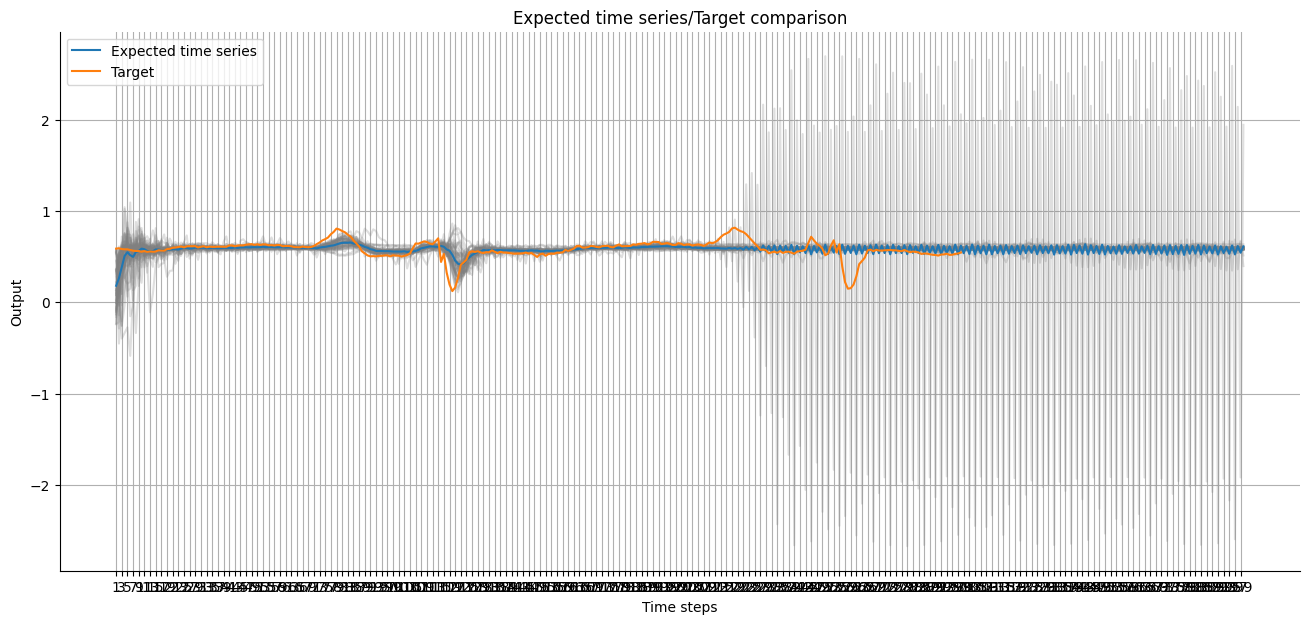

In [36]:
expected_timeseries = torch.cat(
    (
        torch.add(output_forecast[-1, :past_horizon], test_batch[:past_horizon]),
        output_forecast[-1, past_horizon:],
    ),
    dim=0,
).detach()
expected_timeseries_outputs = torch.cat(
    (
        torch.add(output_forecast[:-1, :past_horizon], test_batch[:past_horizon]),
        output_forecast[:-1, past_horizon:],
    ),
    dim=1,
).detach()

visualize_forecasts.plot_time_series(
    expected_time_series=expected_timeseries[:, 0, 0],
    target=test_batch[:, 0, 0],
    uncertainty=expected_timeseries_outputs[:, :, 0, 0].T,
)

In [30]:
torch.save(larger_hcnn_ensemble, f"larger_hcnn_ensemble_{n_models}.pt")

In [33]:
# mpl.rcParams['figure.figsize'] = (16,7)
# from torch.nn.functional import interpolate
fig = visualize_forecasts.heatmap_forecasts(
    expected_timeseries_outputs[:, past_horizon:, 0, 0].T, figsize=(16, 7)
)
# plt.xticks(mpl.ticker.MultipleLocator(20))
# plt.plot(interpolate(expected_timeseries.transpose(0,2), 15*(forecast_horizon-1), mode="linear")[0, 0, :], color="red", label="Expected")
# plt.plot(interpolate(test_batch.transpose(0,2), 15*(forecast_horizon-1), mode="linear")[0, 0, :], color="black", linestyle="--", label="Target")
# plt.legend()
plt.show()

KeyboardInterrupt: 

In [57]:
data_generating_model = HCNN(
    n_state_neurons=n_state_neurons,
    n_features_Y=n_features_Y,
    past_horizon=past_horizon,
    forecast_horizon=forecast_horizon,
    sparsity=sparsity,
)

In [58]:
optimizer = torch.optim.Adam(data_generating_model.parameters(), lr=0.001)
loss_function = torch.nn.MSELoss()

In [59]:
targets = torch.zeros((past_horizon, batchsize, n_features_Y))

In [52]:
Y_batches[0, :, 0].unsqueeze(1).shape

torch.Size([30, 1, 2])

In [65]:
with torch.no_grad():
    data_generating_model.eval()
    input = Y_batches[0, :, 0].unsqueeze(1)
    print(input)
    print(input.shape)
    output_forecast = data_generating_model(Y_batches[0, :, 0].unsqueeze(1))
    print(output_forecast.shape)
    forecast = output_forecast[-1, past_horizon:]

tensor([[[ 1.0072,  0.9795]],

        [[ 1.6733,  0.8716]],

        [[ 1.2485,  0.4338]],

        [[ 0.4618,  0.2912]],

        [[ 0.0631,  0.2123]],

        [[ 0.0744,  0.0948]],

        [[ 1.1101,  0.9562]],

        [[ 0.2243,  0.4533]],

        [[ 0.0908,  0.8648]],

        [[-0.2845,  0.4879]],

        [[ 0.8784,  0.8971]],

        [[ 1.7271,  0.9391]],

        [[ 0.9963,  0.2396]],

        [[ 0.5650,  0.3424]],

        [[ 0.2504,  0.3399]]])
torch.Size([15, 1, 2])
torch.Size([30, 1, 2])


In [ ]:
def generate_data_from_hcnn(model, init_state, n_data, stepsize=2):
    new_data = []
    current_state = init_state
    for i in range(n_data):
        forcast = model(current_state)[-1, past_horizon : past_horizon + stepsize]
        new_data.append(forcast)
        current_state = torch.cat((current_state[:, 1:], new_state), 1)

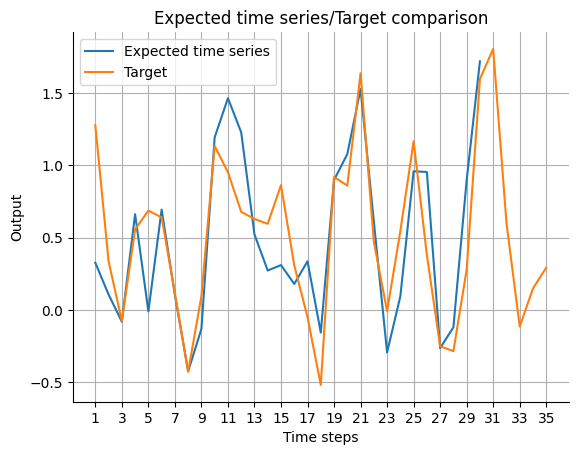

In [49]:
expected_timeseries = torch.cat(
    (torch.add(past_error.squeeze(), Y[:past_horizon]), forecast.squeeze()), dim=0
).detach()

visualize_forecasts.plot_time_series(
    expected_time_series=expected_timeseries[:, 0],
    target=Y[: past_horizon + forecast_horizon, 0],
)

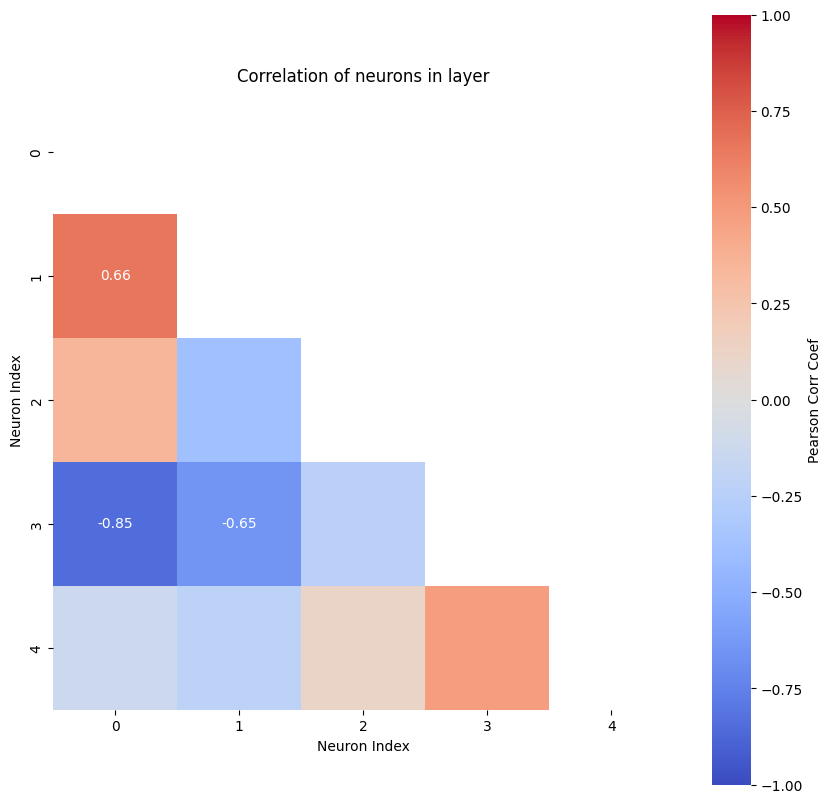

The most correlated neurons are the ones with indices  [3, 0]
The according Pearson correlation coefficient is -0.85


In [35]:
with torch.no_grad():
    states_for_correlation = torch.empty(
        (Y_batches.shape[0], batchsize, n_state_neurons)
    )

    for batch_index in range(0, Y_batches.shape[0]):
        Y_batch = Y_batches[batch_index]
        model_output = hcnn_model(Y_batch)
        states_for_correlation[batch_index] = hcnn_model.state[past_horizon]
    states_for_correlation = states_for_correlation.reshape((-1, n_state_neurons))

    corr_matrix, max_corr, ind_neurons = nchl.hl_size_analysis(states_for_correlation)

In [37]:
hcnn_model.state[0].shape

torch.Size([1, 5])

In [7]:
hcnn_ensemble = Ensemble(
    model=hcnn_model, n_models=n_models, sparsity=sparsity, combination_type="median"
)

### Build a deterministic timeseries generator
We use a HCNN as our data generating process:
- Trained on synthetic data to get a resonable HCNN state
- To ensure that the variation of the produced time series cannot also be explained by a less complex model, the state size is chosen in such a way that there is only a low redundancy/correlation between the individual neurons (target value: max. 0.7).


+ vary the complexity by changing the size of the state matrix
+ for a given init state the process is fully deterministic

&rarr; No Forcast Uncertainty
